# Mapping Collaborators' Social Capital to Directors' Career Timelines

So far, I’ve built directors’ career timelines and computed social capital for everyone in the film collaboration network. In this notebook, I bring those pieces together and construct director-year features that describe the social capital embedded in their teams and in their own network positions.

I map each director’s collaborators in rolling three-year windows, attach their brokerage metrics and degree centrality, summarize these team profiles into director-level features, and add both debut-year conditions and directors’ own brokerage scores. The result is a director-year dataset that captures how both personal network position and team composition evolve across a career — the core feature set for modeling who stays in the industry and who drops out.

# Imports & Setup

In [ ]:
# Core
import os
import random
import pickle

# Data wrangling
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

# Project root 
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')


# Load Director and Collaboration Datasets

This notebook relies on three inputs:

- a cross-sectional summary of each director’s first 10 years,
- a year-by-year panel tracking their careers over the same horizon, and
- a collaboration dataset covering every creative worker on every film from 2000–2023.

Together, these give us the pieces to connect directors to their films, their collaborators, and their evolving career timelines.

In [ ]:
# Load cross-sectional data on directors' career
directors_cross_sectional = pd.read_csv('directors_cross_sectional.csv')
# load yearly data of directors
directors_years = pd.read_csv('directors_years.csv')
# Load data on all collaborations among creative workers for movies released between 2000 and 2023.
movies_collaborations_2000_2023 = pd.read_csv('movies_collaborations_2000_2023.csv')

In [3]:
# Display the first few rows of each dataset to understand their structure
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.0,1,1.0
1,nm1130611,2004,11.0,0,0.0
2,nm0290651,2003,11.0,0,0.0
3,nm0404033,2003,5.0,1,1.0
4,nm0000417,2005,2.0,1,1.0


In [ ]:
directors_years.head()

,nconst_director,year,debut_year
0,nm1131265,2004,2004
1,nm1131265,2005,2004
2,nm1131265,2006,2004
3,nm1131265,2007,2004
4,nm1131265,2008,2004


In [4]:
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


# Linking Directors to Collaborators

Here we link each director to the creative workers they’ve collaborated with on movies. 

In [ ]:
# Map each director to their movies (from filmography table)
directors_network = pd.merge(
    directors_cross_sectional[['nconst_director', 'debut_year']], 
    movies_collaborations_2000_2023.drop(columns=['category']), 
    left_on='nconst_director', right_on='nconst', how='left'
    ).drop(columns='nconst')

# For those movies, pull all coworkers (collaborators)
directors_network = pd.merge(
    directors_network, 
    movies_collaborations_2000_2023.drop(columns=['category']), 
    on=['tconst','startYear'], how='inner'
).rename(columns={"nconst": "nconst_collaborator"})

# Remove self‑loops and unnecessary duplicates (director == collaborator)
directors_network = directors_network[
    directors_network['nconst_director'] != directors_network['nconst_collaborator']
    ]

In [6]:
# Display the first few rows of the network dataset 
directors_network.head()

,nconst_director,debut_year,tconst,startYear,nconst_collaborator
0,nm1131265,2004,tt0108549,2004.0,nm0168948
2,nm1131265,2004,tt0108549,2004.0,nm1130611
3,nm1131265,2004,tt0108549,2004.0,nm0111876
4,nm1131265,2004,tt0108549,2004.0,nm2382648
5,nm1131265,2004,tt0108549,2004.0,nm0828024


# Constructing Rolling Collaboration Windows

Career opportunities are shaped by recent collaborations. For each year in a director's career, I focus on the previous three years of films and compile the unique set of collaborators they worked with in that window.

In [ ]:
# Converting director and collaborator IDs to categorical data types for efficient memory use
directors_network[['nconst_director', 'nconst_collaborator']] = directors_network[['nconst_director', 'nconst_collaborator']].astype('category')
directors_years.loc[:, 'nconst_director'] = directors_years['nconst_director'].astype('category')

# Merging the yearly data of directors with their network data based on director IDs
directors_years_network = pd.merge(
    directors_years, 
    directors_network.drop_duplicates(subset=['tconst', 'nconst_director', 'nconst_collaborator']), 
    on=['nconst_director', 'debut_year'], 
    how='left'
    )

# Calculating the time frame (the preceding three years) to identify collaborators 
directors_years_network['year_min'] = directors_years_network['year'] - 3
directors_years_network['year_max'] = directors_years_network['year'] - 1

# Filtering to include only collaborations within the specified time frame
directors_years_network = directors_years_network[
    (directors_years_network['startYear'] >= directors_years_network['year_min']) & 
    (directors_years_network['startYear'] <= directors_years_network['year_max'])
    ]

In [10]:
# Display the first few rows of the data linking the directors to recent collaborators
directors_years_network.head()

,nconst_director,year,debut_year,tconst,startYear,nconst_collaborator,year_min,year_max
12,nm1131265,2005,2004,tt0108549,2004.0,nm0168948,2002,2004
13,nm1131265,2005,2004,tt0108549,2004.0,nm1130611,2002,2004
14,nm1131265,2005,2004,tt0108549,2004.0,nm0111876,2002,2004
15,nm1131265,2005,2004,tt0108549,2004.0,nm2382648,2002,2004
16,nm1131265,2005,2004,tt0108549,2004.0,nm0828024,2002,2004


In [ ]:
# Grouping the data by director and year, then compiling a list of unique collaborators for each director-year pair.
collaborators_by_year = directors_years_network.groupby(['nconst_director', 'year'])['nconst_collaborator'].apply(lambda x: list(set(x.dropna()))).reset_index()

# Display the first few rows of the result
collaborators_by_year.head()

,nconst_director,year,nconst_collaborator
0,nm0000083,2008,"[nm0613273, nm0690875, nm0917916, nm1677271, n..."
1,nm0000083,2009,"[nm0613273, nm0690875, nm0917916, nm1677271, n..."
2,nm0000083,2010,"[nm0613273, nm0690875, nm0917916, nm1677271, n..."
3,nm0000083,2011,"[nm0613273, nm1677271, nm0662263, nm1730786]"
4,nm0000083,2012,"[nm0613273, nm1677271, nm0662263, nm1730786]"


In [ ]:
# Add information on directors' debut year
collaborators_by_year = collaborators_by_year.merge(directors_cross_sectional[['nconst_director', 'debut_year']], how='left')

# Computing collaborator degree centrality 

Previously, I calculated annual brokerage scores (constraint, effective size, and local clustering) for every creative worker in the film industry from 2003 to 2023. Now, we compute a simpler network measure: degree centrality. This counts how many unique collaborators a person has within a given window. 

Unlike more complicated measures (like brokerage scores), degree centrality is easy to compute without constructing large-scale network graphs. It is also highly interpretable, offering a direct glimpse into the size of a person’s professional network.

In [20]:
# Display the first few rows of the dataset to understand its structure and contents.
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


In [21]:
# Display the first few rows of the 'merged_data' dataset to understand its structure and contents.
directors_years_network.head()

,nconst_director,year,debut_year,tconst,startYear,nconst_collaborator,year_min,year_max
12,nm1131265,2005,2004,tt0108549,2004.0,nm0168948,2002,2004
13,nm1131265,2005,2004,tt0108549,2004.0,nm1130611,2002,2004
14,nm1131265,2005,2004,tt0108549,2004.0,nm0111876,2002,2004
15,nm1131265,2005,2004,tt0108549,2004.0,nm2382648,2002,2004
16,nm1131265,2005,2004,tt0108549,2004.0,nm0828024,2002,2004


In [22]:
# Extract unique pairs of collaborators and years from the merged dataset to avoid duplication in analysis.
unique_collaborator_years = directors_years_network[['nconst_collaborator', 'year']].drop_duplicates().reset_index(drop=True)

# Display the first few rows of the data to understand the structure.
unique_collaborator_years.head()

,nconst_collaborator,year
0,nm0168948,2005
1,nm1130611,2005
2,nm0111876,2005
3,nm2382648,2005
4,nm0828024,2005


In [ ]:
# Define a function to calculate the degree centrality for each collaborator in each director-year pair.
# Degree centrality measures how many direct connections (collaborators) each individual has, indicating their network influence.
def calculate_degree_centrality(unique_collaborator_years, movies_collaborations_df):
    degree_centrality_list = [] # Initialize an empty list to collect degree centrality results

    # Iterate over each row in the merged data to calculate degree centrality for each collaborator
    for _, row in unique_collaborator_years.iterrows():
        year = row['year']
        nconst_collaborator = row['nconst']
        year_min = year - 3 # Set the start of the timeframe to three years prior.

        # Identify movies the collaborator has worked on within the timeframe
        relevant_movies = movies_collaborations_df[
            (movies_collaborations_df['nconst'] == nconst_collaborator) &
            (movies_collaborations_df['startYear'] >= year_min) &
            (movies_collaborations_df['startYear'] < year)
        ]['tconst'].unique()

        # Fetch all collaborators for those movies, excluding the current collaborator
        all_collaborators_for_movies = movies_collaborations_df[
            (movies_collaborations_df['tconst'].isin(relevant_movies)) &
            (movies_collaborations_df['nconst'] != nconst_collaborator)
        ]['nconst'].unique()

        # Calculate the degree centrality as the count of unique collaborators
        degree_centrality = len(all_collaborators_for_movies)

        # Append results to the list
        degree_centrality_list.append({
            'year': year,
            'nconst_collaborator': nconst_collaborator,
            'degree_centrality': degree_centrality
        })

    # Convert the list to a DataFrame for further analysis
    return pd.DataFrame(degree_centrality_list)

# Calculate degree centrality for collaborators
collaborator_degree_centrality = calculate_degree_centrality(unique_collaborator_years, movies_collaborations_2000_2023)

# Save the degree centrality results in a CSV file for future reference.
collaborator_degree_centrality.to_csv('collaborator_degree_centrality.csv', index=False)

In [23]:
# Display the first few rows of the calculated degree centrality data to understand its structure.
collaborator_degree_centrality.head()

,year,nconst_collaborator,degree_centrality
0,2004,nm0168948,3
1,2004,nm1130611,0
2,2004,nm0111876,0
3,2004,nm2382648,0
4,2004,nm0828024,0


In [24]:
# Convert degree centrality results to a dictionary for quick lookup during scoring.
collaborator_degree_centrality = collaborator_degree_centrality.set_index(['nconst_collaborator', 'year'])['degree_centrality'].to_dict()

In [26]:
with open('collaborator_degree_centrality.pkl', 'wb') as f:
        pickle.dump(collaborator_degree_centrality, f)

# Map Collaborators’ Social Capital to Each Director-Year

Previously, I calculated annual brokerage scores (constraint, effective size, local clustering) for every creative worker in the industry. Here, I bring those metrics—and the degree centrality just computed—into the director–year panel.

For each director-year, I map the brokerage and centrality scores of everyone they worked with in the corresponding three-year window. This lets us characterize not just *who* they worked with, but *what kind of network positions* those collaborators occupy.

## Load brokerage dictionaries (precomputed from prior notebook)

In [ ]:
# Loading brokerage social capital metrics from a serialized file.
# This data includes brokerage scores for every filmmaker in the network by year
brokerage_scores_by_year = pd.read_pickle('brokerage_scores_by_year.pkl')

In [ ]:
# Print the dictionary keys, which are the years for which data is available.
print("Years in the dataset:", list(brokerage_scores_by_year.keys()))

Years in the dataset: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [29]:
# Check the structure of a nested dictionary by picking a sample year
sample_year = next(iter(brokerage_scores_by_year))  # Get the first year in the dictionary
# Print the keys of the nested dictionary for the first year in the data, which are the types of brokerage scores available.
print(f"Brokerage score types available in {sample_year}:", list(brokerage_scores_by_year[sample_year].keys()))

Brokerage score types available in 2003: ['constraint', 'effective_size', 'local_clustering']


In [30]:
# Pick one type of score to sample, for example 'constraint'
score_type = 'constraint'
# Sample 10 random IDs within the 'constraint' scores
sample_ids = random.sample(list(brokerage_scores_by_year[sample_year][score_type].keys()), 10)
# Print the constraint scores for the randomly selected people
print(f"Random sample of {score_type} scores for {sample_year}:")
for nconst in sample_ids:
        print(f"ID {nconst}: {brokerage_scores_by_year[sample_year][score_type][nconst]}")

Random sample of constraint scores for 2003:
ID nm0411654: 0.169909408226668
ID nm1384768: 0.6480000000000001
ID nm2013346: 0.765625
ID nm9672018: 0.925925925925926
ID nm1164606: 0.42653155555555566
ID nm0533301: 0.5336859504132233
ID nm0885537: 0.14138705575575372
ID nm0831578: 0.6033347800925927
ID nm0459508: 0.5681382716049383
ID nm1420055: 0.6865234375


## Map collaborator‑level brokerage metrics for each year of director career

In [33]:
# Defining a function to map brokerage scores (constraint, effective size, and local clustering) and degree centrality 
# to each collaborator for a given year
def map_all_brokerage_scores(row):
    year = row['year']  # The year under consideration
    collaborators = row['nconst_collaborator']  # List of collaborator IDs for the director in that year
    brokerage_scores = []  # Initialize a list to hold the brokerage scores for each collaborator
    
    # Iterate through each collaborator's ID
    for nconst in collaborators:
        # Extract brokerage scores
        constraint_score = brokerage_scores_by_year.get(year, {}).get('constraint', {}).get(nconst, None)
        effective_size_score = brokerage_scores_by_year.get(year, {}).get('effective_size', {}).get(nconst, None)
        local_clustering_score = brokerage_scores_by_year.get(year, {}).get('local_clustering', {}).get(nconst, None)
        
        # Fetch degree centrality score from the dictionary
        degree_centrality_score = collaborator_degree_centrality.get((nconst, year), None)
        
        # Append the retrieved scores to a list
        brokerage_scores.append({
            nconst: {
                'constraint': constraint_score,
                'effective_size': effective_size_score,
                'local_clustering': local_clustering_score,
                'degree_centrality': degree_centrality_score 
            }
        })
    
    return brokerage_scores

# Apply the function to each row in the dataset to associate each director-year pair with their collaborators' brokerage scores.
collaborators_by_year['brokerage_scores'] = collaborators_by_year.apply(map_all_brokerage_scores, axis=1)

In [34]:
# Set display options to show entire text of brokerage scores in the DataFrame output for better verification
pd.set_option('display.max_colwidth', None)

# Display the first few rows of the DataFrame after mapping brokerage scores to verify correct mapping
collaborators_by_year.head(10)

,nconst_director,year,nconst_collaborator,debut_year,brokerage_scores
0,nm0000083,2008,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19}}]"
1,nm0000083,2009,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0690875': {'constraint': 0.30614693877551025, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10}}, {'nm0917916': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14}}]"
2,nm0000083,2010,"[nm0613273, nm0690875, nm0917916, nm1677271, nm1730786, nm0653114, nm0662263]",2007,"[{'nm0613273': {'constraint': 0.4229693356934609, 'effective_size': 2.7142857142857144, 'local_clustering': 0.7142857142857143, 'degree_centrality': 7}}, {'nm0690875': {'constraint': 0.513961224489796, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0917916': {'constraint': 0.513961224489796, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm1677271': {'constraint': 0.4229693356934609, 'effective_size': 2.7142857142857144, 'local_clustering': 0.7142857142857143, 'degree_centrality': 7}}, {'nm1730786': {'constraint': 0.5006975446428571, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm0653114': {'constraint': 0.3462925170068027, 'effective_size': 4.75, 'local_clustering': 0.4642857142857143, 'degree_centrality': 8}}, {'nm0662263': {'constraint': 0.3168048469387755, 'effective_size': 5.0, 'local_clustering': 0.42857142857142855, 'degree_centrality': 8}}]"
3,nm0000083,2011,"[nm0613273, nm1677271, nm0662263, nm1730786]",2007,"[{'nm0613273': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm1677271': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm0662263': {'constraint': 0.3657724808673469, 'effective_size': 5.0, 'local_clustering': 0.42857142857142855, 'degree_centrality': 8}}, {'nm1730786': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}]"
4,nm0000083,2012,"[nm0613273, nm1677271, nm0662263, nm1730786]",2007,"[{'nm0613273': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm1677271': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm0662263': {'constraint': 0.3828125, 'effective_size': 5.0, 'local_clustering': 0.42857142857142855, 'degree_centrality': 8}}, {'nm1730786': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}]"
5,nm0000083,2018,"[nm4895344, nm4896032]",2007,"[{'nm4895344': {'constraint': 1.125, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 2}}, {'nm4896032': {'constraint': 1.125, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 2}

## EDA collaborators' social capital metrics 

To sanity-check the social capital metrics, let's inspect distributions and correlations. This step helps verify that the network measures behave as expected and that extreme cases (e.g., very high constraint or clustering) are sensible.


### Flatten collaborator scores for diagnostics

In [ ]:
# Initialize an empty list to collect data for creating a new DataFrame dedicated to collaborators' scores
collaborator_brokerage = []

# Loop through each row in the collaborators_by_year DataFrame to extract individual brokerage scores
for _, row in collaborators_by_year.iterrows():
    # Each 'brokerage_scores' contains multiple dictionaries, one for each collaborator
    for score_dict in row['brokerage_scores']:
        # Extract each collaborator's ID and their respective scores
        for nconst, scores in score_dict.items():
            # Append each collaborator's scores to the list as a dictionary
            collaborator_brokerage.append({
                'collaborator_id': nconst,
                'constraint': scores.get('constraint'),
                'effective_size': scores.get('effective_size'),
                'local_clustering': scores.get('local_clustering'),
                'degree_centrality': scores.get('degree_centrality'),
            })

# Convert the list of score dictionaries into a DataFrame for easier analysis
collaborator_brokerage = pd.DataFrame(collaborator_brokerage)

# Display the first few rows of the new DataFrame to understand its structure
collaborator_brokerage.head()

,collaborator_id,constraint,effective_size,local_clustering,degree_centrality
0,nm0613273,0.514127,1.000000,1.000000,5
1,nm0690875,0.303648,6.000000,0.444444,10
2,nm0917916,0.514127,1.000000,1.000000,5
3,nm1677271,0.514127,1.000000,1.000000,5
4,nm0653114,0.125969,15.210526,0.210526,19


### Descriptive statistics

In [38]:
# Setting display format for floating point numbers to ensure consistent formatting in output
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display descriptive statistics for all collaborators to understand overall distribution of scores
collaborator_brokerage.describe()

,constraint,effective_size,local_clustering,degree_centrality
count,1542919.00,1542919.00,1542919.00,1542919.00
mean,0.48,4.99,0.74,8.62
std,0.26,11.03,0.34,11.35
min,0.01,1.00,0.00,1.00
25%,0.27,1.00,0.44,4.00
50%,0.48,1.00,1.00,5.00
75%,0.65,5.75,1.00,10.00
max,1.12,396.02,1.00,399.00


### Correlation analyses

In [ ]:
# Compute the correlation matrix
correlation_matrix = collaborator_brokerage[['constraint', 'effective_size', 'local_clustering', 'degree_centrality']].corr()

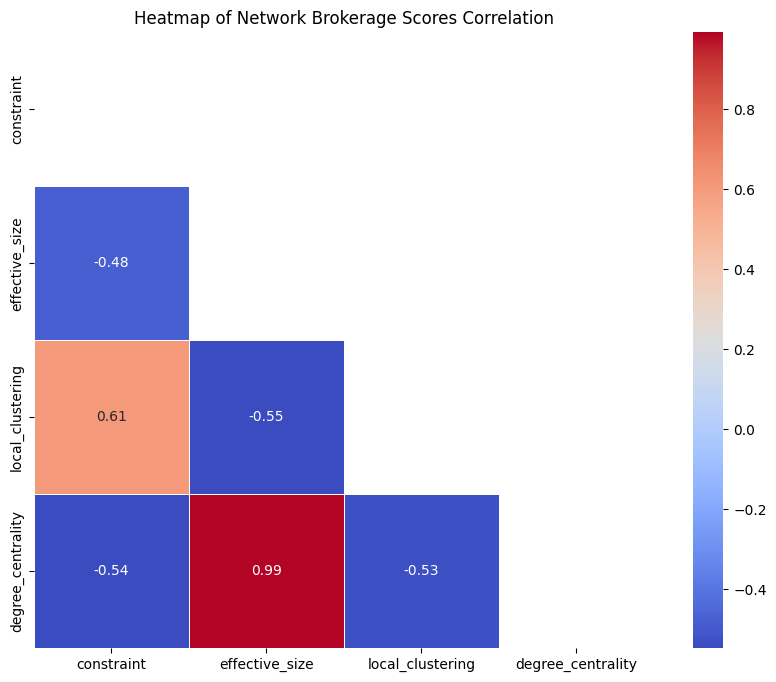

In [41]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))  # Set the figure size
# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title('Heatmap of Network Brokerage Scores Correlation')
plt.show()

Overall, the metrics behave as expected: higher constraint aligns with tighter clustering and fewer non-redundant contacts, while effective size and degree centrality move closely together as indicators of network reach.

# Creating Reverse Scores for Brokerage Metrics

Because higher constraint and higher local clustering indicate *less* brokerage potential, I create reverse versions of these metrics so that “higher” consistently means “more opportunity to span structural holes.” I also handle edge cases, such as individuals with only one tie, to keep the resulting features interpretable and stable for modeling.

In [46]:
epsilon = 1e-5  # Define a very small number

# define functions for calculating reverse scores 
def calculate_reverse_constraint(constraint, degree_centrality):
    if constraint is None:
        return 0
    elif degree_centrality == 1:
        return epsilon
    elif constraint > 1:
        return epsilon
    else:
        return 1 + epsilon - constraint

def calculate_reverse_local_clustering(local_clustering, degree_centrality):
    if local_clustering is None:
        return 0
    elif degree_centrality == 1:
        return epsilon
    else:
        return 1 + epsilon - local_clustering

# define function to recalculate constraint and local clustering and calculate their reverse scores
def apply_reverse_scores(row):
    updated_scores = []
    for score_dict in row['brokerage_scores']:
        for nconst, scores in score_dict.items():
            # Fetch original scores
            original_constraint = scores.get('constraint')
            original_local_clustering = scores.get('local_clustering')
            degree_centrality = scores.get('degree_centrality')

            # Initialize recalculated scores with original values or 0 if None
            recalculated_constraint = original_constraint if original_constraint is not None else 0
            recalculated_local_clustering = original_local_clustering if original_local_clustering is not None else 0

            # Apply conditions for recalculations
            if degree_centrality == 1:
                recalculated_constraint = epsilon
                recalculated_local_clustering = epsilon

            # Calculate reverse scores using the original values
            reverse_constraint = calculate_reverse_constraint(original_constraint, degree_centrality)
            reverse_local_clustering = calculate_reverse_local_clustering(original_local_clustering, degree_centrality)

            # Update the dictionary with original, recalculated, and reverse scores
            scores['recalculated_constraint'] = recalculated_constraint
            scores['recalculated_local_clustering'] = recalculated_local_clustering
            scores['reverse_constraint'] = reverse_constraint
            scores['reverse_local_clustering'] = reverse_local_clustering

            updated_scores.append({nconst: scores})
    return updated_scores

# Apply the function to update brokerage_scores with original, recalculated, and reverse scores
collaborators_by_year['brokerage_scores'] = collaborators_by_year.apply(apply_reverse_scores, axis=1)

In [47]:
# Display the first few rows of the updated DataFrame with the new scores to verify successful computation
collaborators_by_year.head()

,nconst_director,year,nconst_collaborator,debut_year,brokerage_scores
0,nm0000083,2008,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30364764542936296, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6963623545706371, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19, 'recalculated_constraint': 0.1259692370646298, 'recalculated_local_clustering': 0.21052631578947367, 'reverse_constraint': 0.8740407629353703, 'reverse_local_clustering': 0.7894836842105264}}]"
1,nm0000083,2009,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0690875': {'constraint': 0.30614693877551025, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30614693877551025, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6938630612244898, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14, 'recalculated_constraint': 0.1654934959096975, 'recalculated_local_clustering': 0.2857142857142857, 'reverse_constraint': 0.8345165040903025, 'reverse_local_clustering': 0.7142957142857144}}]"
2,nm0000083,2010,"[nm0613273, nm0690875, nm0917916, nm1677271, nm1730786, nm0653114, nm0662263]",2007,"[{'nm0613273': {'constraint': 0.4229693356934609, 'effective_size': 2.7142857142857144, 'local_clustering': 0.7142857142857143, 'degree_centrality': 7, 'recalculated_constraint': 0.4229693356934609, 'recalculated_local_clustering': 0.7142857142857143, 'reverse_constraint': 0.5770406643065391, 'reverse_local_clustering': 0.28572428571428576}}, {'nm0690875': {'constraint': 0.513961224489796, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.

# Aggregating Collaborator Social Capital to the Director-Year Level

Up to this point, we’ve been looking at collaborators one by one. But to understand directors, we need to summarize what kind of social capital is embedded in their teams each year. For each director and year, I compute:

- team size (number of collaborators),
- average collaborator scores (what a “typical” teammate looks like),
- and maximum collaborator scores (whether at least one high-brokerage “super-connector” was present).

These summaries compress a complex bundle of individuals into tidy, director-level features that we can plug directly into survival models.

In [48]:
def compute_stats(row):
    # Extract the list of brokerage scores dictionaries for the row
    brokerage_scores = row['brokerage_scores']
    
    # Initialize lists to hold each type of score for aggregation
    constraint_scores = []
    local_clustering_scores = []
    reverse_constraint_scores = []
    effective_size_scores = []
    reverse_local_clustering_scores = []
    degree_centrality_scores = []
    
    # Iterate through each brokerage scores dictionary, extracting the scores
    for score_dict in brokerage_scores:
        for scores in score_dict.values():
            if 'recalculated_constraint' in scores and scores['recalculated_constraint'] is not None:
                constraint_scores.append(scores['recalculated_constraint'])
            if 'recalculated_local_clustering' in scores and scores['recalculated_local_clustering'] is not None:
                local_clustering_scores.append(scores['recalculated_local_clustering'])
            if 'reverse_constraint' in scores and scores['reverse_constraint'] is not None:
                reverse_constraint_scores.append(scores['reverse_constraint'])
            if 'effective_size' in scores and scores['effective_size'] is not None:
                effective_size_scores.append(scores['effective_size'])
            if 'reverse_local_clustering' in scores and scores['reverse_local_clustering'] is not None:
                reverse_local_clustering_scores.append(scores['reverse_local_clustering'])
            if 'degree_centrality' in scores and scores['degree_centrality'] is not None:
                degree_centrality_scores.append(scores['degree_centrality'])    
    
    # Compute the number of collaborators, average, and maximum for each type of score
    num_collaborators = len(brokerage_scores)
    avg_constraint = np.mean(constraint_scores) if constraint_scores else 0
    max_constraint = np.max(constraint_scores) if constraint_scores else 0
    avg_local_clustering = np.mean(local_clustering_scores) if local_clustering_scores else 0
    max_local_clustering = np.max(local_clustering_scores) if local_clustering_scores else 0
    avg_reverse_constraint = np.mean(reverse_constraint_scores) if reverse_constraint_scores else 0
    max_reverse_constraint = np.max(reverse_constraint_scores) if reverse_constraint_scores else 0
    avg_effective_size = np.mean(effective_size_scores) if effective_size_scores else 0
    max_effective_size = np.max(effective_size_scores) if effective_size_scores else 0
    avg_reverse_local_clustering = np.mean(reverse_local_clustering_scores) if reverse_local_clustering_scores else 0
    max_reverse_local_clustering = np.max(reverse_local_clustering_scores) if reverse_local_clustering_scores else 0
    avg_degree_centrality = np.mean(degree_centrality_scores) if degree_centrality_scores else 0
    max_degree_centrality = np.max(degree_centrality_scores) if degree_centrality_scores else 0
    
    # Return a dictionary with the computed statistics for each type of brokerage score
    return {
        'num_collaborators': num_collaborators,
        'avg_constraint': avg_constraint,
        'max_constraint': max_constraint,
        'avg_local_clustering': avg_local_clustering,
        'max_local_clustering': max_local_clustering,
        'avg_reverse_constraint': avg_reverse_constraint,
        'max_reverse_constraint': max_reverse_constraint,
        'avg_effective_size': avg_effective_size,
        'max_effective_size': max_effective_size,
        'avg_reverse_local_clustering': avg_reverse_local_clustering,
        'max_reverse_local_clustering': max_reverse_local_clustering,
        'avg_degree_centrality': avg_degree_centrality,
        'max_degree_centrality': max_degree_centrality
    }

# Apply the function to each row in the DataFrame to create new columns for the computed statistics
stats = collaborators_by_year.apply(compute_stats, axis=1, result_type='expand')

# Concatenate the original DataFrame with the new statistics DataFrame to include the computed stats
collaborators_by_year = pd.concat([collaborators_by_year, stats], axis=1)

In [49]:
# Display the first few rows of the updated DataFrame with the new variables to verify successful computation
collaborators_by_year.head()

,nconst_director,year,nconst_collaborator,debut_year,brokerage_scores,num_collaborators,avg_constraint,max_constraint,avg_local_clustering,max_local_clustering,avg_reverse_constraint,max_reverse_constraint,avg_effective_size,max_effective_size,avg_reverse_local_clustering,max_reverse_local_clustering,avg_degree_centrality,max_degree_centrality
0,nm0000083,2008,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30364764542936296, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6963623545706371, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19, 'recalculated_constraint': 0.1259692370646298, 'recalculated_local_clustering': 0.21052631578947367, 'reverse_constraint': 0.8740407629353703, 'reverse_local_clustering': 0.7894836842105264}}]",5.00,0.39,0.51,0.73,1.00,0.61,0.87,4.84,15.21,0.27,0.79,8.80,19.00
1,nm0000083,2009,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0690875': {'constraint': 0.30614693877551025, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30614693877551025, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6938630612244898, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14, 'recalculated_constraint': 0.1654934959096975, 'recalculated_local_clustering': 0.2857142857142857, 'reverse_constraint': 0.8345165040903025, 'reverse_local_clustering': 0.7142957142857144}}]",5.00,0.41,0.52,0.75,1.00,0.59,0.83,3.86,10.29,0.25,0.71,7.80,14.00
2,nm0000083,2010,"[nm0613273, nm0690875, nm0917916, nm1677271, nm1730786, nm0653114, nm0662263]",2007,"[{'nm0613273': {'constraint': 0.4229693356934609, 'effective_size': 2.71428571428571

In [50]:
# Save the dataset
collaborators_by_year.to_pickle('collaborators_by_year.pkl')

# Merge Collaborator Features into Directors’ Yearly Timelines

We now merge these collaborator-based features back into each director’s yearly career data. This creates a comprehensive panel: for every year of a director’s career, we know not just what they did, but also what kinds of collaborators they worked with.

In [51]:
# Load the 'directors_years' DataFrame, which includes annual data for each director
directors_years = pd.read_csv("directors_years.csv")

# Display the first few rows to inspect the structure of the data
directors_years.head()

,nconst_director,year,debut_year
0,nm1131265,2004,2004
1,nm1131265,2005,2004
2,nm1131265,2006,2004
3,nm1131265,2007,2004
4,nm1131265,2008,2004


In [ ]:
# Merge the directors' annual data with the collaborators' network statistics from the 'collaborators_by_year' dataset.
directors_years_collaborator_brokerage = pd.merge(
    directors_years, 
    collaborators_by_year.drop(columns=['nconst_collaborator', 'brokerage_scores']),
    on=['nconst_director', 'year', 'debut_year'],
    how='left'
)

In [54]:
# Display the first 25 rows to verify the merge was successful and to understand the updated structure.
directors_years_collaborator_brokerage.head(25)

,nconst_director,year,debut_year,num_collaborators,avg_constraint,max_constraint,avg_local_clustering,max_local_clustering,avg_reverse_constraint,max_reverse_constraint,avg_effective_size,max_effective_size,avg_reverse_local_clustering,max_reverse_local_clustering,avg_degree_centrality,max_degree_centrality
0,nm1131265,2004,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,3.64,14.22,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,3.00,11.00,0.14,0.71,7.00,15.00
4,nm1131265,2008,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,nm1131265,2009,2004,5.00,0.53,0.59,0.89,1.00,0.47,0.73,2.00,6.00,0.11,0.56,6.00,10.00
6,nm1131265,2010,2004,5.00,0.53,0.59,0.89,1.00,0.47,0.71,2.00,6.00,0.11,0.56,6.00,10.00
7,nm1131265,2011,2004,5.00,0.53,0.59,0.89,1.00,0.47,0.71,2.00,6.00,0.11,0.56,6.00,10.00
8,nm1131265,2012,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,nm1131265,2013,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Handling Directors with No Network Data

Not all directors have complete data regarding their collaborators:
- Directors with inactive career periods: For directors with periods of inactivity (no films releases in the preceding three years), we assign a score of 0 for collaborators' network metrics, indicating no network activity during those inactive periods.
- Directors without collaborators: For directors who do not have any collaborators listed on their movies, we retain NA values in the brokerage scores to reflect the absence of network data.

In [59]:
# Display the first few rows of each dataset to understand their structure and content
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.00,1,1.00
1,nm1130611,2004,11.00,0,0.00
2,nm0290651,2003,11.00,0,0.00
3,nm0404033,2003,5.00,1,1.00
4,nm0000417,2005,2.00,1,1.00


In [60]:
directors_network.head()

,nconst_director,debut_year,tconst,startYear,nconst_collaborator
0,nm1131265,2004,tt0108549,2004.00,nm0168948
2,nm1131265,2004,tt0108549,2004.00,nm1130611
3,nm1131265,2004,tt0108549,2004.00,nm0111876
4,nm1131265,2004,tt0108549,2004.00,nm2382648
5,nm1131265,2004,tt0108549,2004.00,nm0828024


In [61]:
# Extract sets of unique director IDs from both the full filmography and the network data to identify discrepancies.
directors_cross_sectional = set(directors_cross_sectional['nconst_director'].unique())
directors_in_network = set(directors_network['nconst_director'].unique())

# Identify directors who are present in the full filmography dataset but not in the network dataset.
# These directors do not have any network connections recorded, possibly due to missing data or other issues.
directors_no_networks = directors_cross_sectional - directors_in_network

In [62]:
# Display the number of directors who have no network data.
len(directors_no_networks)

4300

In [63]:
# Define the columns that we need to fill in NA values. These columns represent collaborators' network statistics.
columns_to_fill_na = [
    'num_collaborators', 
    'avg_constraint', 
    'max_constraint', 
    'avg_local_clustering', 
    'max_local_clustering',
    'avg_reverse_constraint', 
    'max_reverse_constraint', 
    'avg_effective_size', 
    'max_effective_size', 
    'avg_reverse_local_clustering', 
    'max_reverse_local_clustering',
    'avg_degree_centrality',
    'max_degree_centrality'
]

# Create a Boolean Series to identify directors who have network data.
# This Series is true for directors with network information and false for those without.
has_network_info = ~directors_years_collaborator_brokerage['nconst_director'].isin(directors_no_networks)

# For directors with available network data, replace NA values with 0 in the specified network statistic columns.
# This step ensures that absence of data due to inactivity or lack of connections is represented as 0 rather than NA.
directors_years_collaborator_brokerage.loc[has_network_info, columns_to_fill_na] = directors_years_collaborator_brokerage.loc[has_network_info, columns_to_fill_na].fillna(0)

In [66]:
# List of specific columns to rename
columns_to_rename = [
    'avg_constraint', 
    'max_constraint', 
    'avg_local_clustering', 
    'max_local_clustering',
    'avg_reverse_constraint',
    'max_reverse_constraint',
    'avg_effective_size',
    'max_effective_size',
    'avg_reverse_local_clustering',
    'max_reverse_local_clustering',
    'avg_degree_centrality',
    'max_degree_centrality'
]

# Creating a dictionary to rename the specific columns
rename_dict = {col: f"collaborator_{col}" for col in columns_to_rename}

# Renaming the specific columns
directors_years_collaborator_brokerage.rename(columns=rename_dict, inplace=True)

# Print the updated DataFrame to check the new column names
directors_years_collaborator_brokerage.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,collaborator_avg_effective_size,collaborator_max_effective_size,collaborator_avg_reverse_local_clustering,collaborator_max_reverse_local_clustering,collaborator_avg_degree_centrality,collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,3.64,14.22,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,3.00,11.00,0.14,0.71,7.00,15.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Debut-Year Snapshots of Collaborator Social Capital

Early conditions can matter a lot: who you work with on your first project may shape your trajectory. To capture this, I construct a debut-year snapshot that records the social capital of a director’s collaborators at the start of their career (the year following debut in this rolling-window structure).

These debut features let us later test whether initial exposure to well-connected or brokerage-rich collaborators predicts longer careers, above and beyond what happens later.

## Map debut collaborators' brokerage scores to panel data

In [67]:
# Filter the 'directors_years' DataFrame to only include the year following directors' debut
# This subset will focus on capturing the conditions at the start of each director's career.
debut_stats = directors_years_collaborator_brokerage[directors_years_collaborator_brokerage['year'] == directors_years_collaborator_brokerage['debut_year'] + 1]

# Display a preview of 'debut_stats' to confirm the correct rows have been selected.
debut_stats.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,collaborator_avg_effective_size,collaborator_max_effective_size,collaborator_avg_reverse_local_clustering,collaborator_max_reverse_local_clustering,collaborator_avg_degree_centrality,collaborator_max_degree_centrality
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
21,nm1130611,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
41,nm0290651,2004,2003,1.00,0.41,0.41,0.60,0.60,0.59,0.59,2.60,2.60,0.40,0.40,5.00,5.00
62,nm0404033,2004,2003,5.00,0.48,0.56,0.84,1.00,0.52,0.87,4.22,17.10,0.16,0.80,8.20,21.00
83,nm0000417,2006,2005,4.00,0.62,0.70,0.86,1.00,0.38,0.61,1.86,4.43,0.14,0.57,4.75,7.00


In [68]:
# Select and concatenate the director ID and the last nine columns from 'debut_stats' which contain the relevant 
# network statistics for further analysis.
debut_stats = pd.concat([debut_stats.iloc[:, :1], debut_stats.iloc[:, -13:]], axis=1)

# Rename columns to specifically indicate these statistics are from the directors' debut years.
# This helps in distinguishing these values from their entire career statistics in the dataset.
debut_stats.rename(columns={
    'num_collaborators': 'debut_num_collaborators',
    'collaborator_avg_constraint': 'debut_collaborator_avg_constraint',
    'collaborator_max_constraint': 'debut_collaborator_max_constraint',
    'collaborator_avg_local_clustering': 'debut_collaborator_avg_local_clustering',
    'collaborator_max_local_clustering': 'debut_collaborator_max_local_clustering',
    'collaborator_avg_reverse_constraint': 'debut_collaborator_avg_reverse_constraint',
    'collaborator_max_reverse_constraint': 'debut_collaborator_max_reverse_constraint',
    'collaborator_avg_effective_size': 'debut_collaborator_avg_effective_size',
    'collaborator_max_effective_size': 'debut_collaborator_max_effective_size',
    'collaborator_avg_reverse_local_clustering': 'debut_collaborator_avg_reverse_local_clustering',
    'collaborator_max_reverse_local_clustering': 'debut_collaborator_max_reverse_local_clustering',
    'collaborator_avg_degree_centrality': 'debut_collaborator_avg_degree_centrality',
    'collaborator_max_degree_centrality': 'debut_collaborator_max_degree_centrality'
}, inplace=True)

# Display the first few rows of updated 'debut_stats' to ensure the column renaming was successful.
debut_stats.head()

,nconst_director,debut_num_collaborators,debut_collaborator_avg_constraint,debut_collaborator_max_constraint,debut_collaborator_avg_local_clustering,debut_collaborator_max_local_clustering,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
1,nm1131265,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
21,nm1130611,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
41,nm0290651,1.00,0.41,0.41,0.60,0.60,0.59,0.59,2.60,2.60,0.40,0.40,5.00,5.00
62,nm0404033,5.00,0.48,0.56,0.84,1.00,0.52,0.87,4.22,17.10,0.16,0.80,8.20,21.00
83,nm0000417,4.00,0.62,0.70,0.86,1.00,0.38,0.61,1.86,4.43,0.14,0.57,4.75,7.00


In [69]:
# Merge the modified 'debut_stats' back into the directors' yearly data on the director ID ('nconst_director'),
# enhancing the dataset with collaborators' network statistics from each director's debut year.
directors_years_collaborator_brokerage = pd.merge(directors_years_collaborator_brokerage, debut_stats, on='nconst_director', how='left')

In [70]:
# Display the first few rows of the data after merging to confirm the addition of debut year statistics.
directors_years_collaborator_brokerage.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,...,debut_collaborator_avg_local_clustering,debut_collaborator_max_local_clustering,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00


## Map debut collaborators' brokerage scores to cross-sectional data

In [72]:
# Load a separate cross-sectional dataset that summarizes directors' careers 10 years after debut.
directors_cross_sectional = pd.read_csv("directors_cross_sectional.csv")

In [73]:
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.00,1,1.00
1,nm1130611,2004,11.00,0,0.00
2,nm0290651,2003,11.00,0,0.00
3,nm0404033,2003,5.00,1,1.00
4,nm0000417,2005,2.00,1,1.00


In [ ]:
# Merge the debut year statistics into the cross-sectional dataset, aligning data by director ID.
# This operation integrates collaborators' network statistics into the broader career summaries.
directors_cross_sectional_social_capital = pd.merge(directors_cross_sectional[['nconst_director']], debut_stats, on='nconst_director', how='left')

In [8]:
# Display the first few rows of the updated cross-sectional dataset to verify the successful merge of debut year data.
directors_cross_sectional_social_capital.head()

,nconst_director,debut_num_collaborators,debut_collaborator_avg_constraint,debut_collaborator_max_constraint,debut_collaborator_avg_local_clustering,debut_collaborator_max_local_clustering,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,5.0,0.487946,0.568138,0.843137,1.0,0.512064,0.832831,3.666667,14.333333,0.156873,0.784324,7.60,18.0
1,nm1130611,5.0,0.487946,0.568138,0.843137,1.0,0.512064,0.832831,3.666667,14.333333,0.156873,0.784324,7.60,18.0
2,nm0290651,1.0,0.408730,0.408730,0.600000,0.6,0.591280,0.591280,2.600000,2.600000,0.400010,0.400010,5.00,5.0
3,nm0404033,5.0,0.477651,0.563944,0.839048,1.0,0.522359,0.867529,4.219048,17.095238,0.160962,0.804772,8.20,21.0
4,nm0000417,4.0,0.619771,0.697465,0.857143,1.0,0.380239,0.613321,1.857143,4.428571,0.142867,0.571439,4.75,7.0


In [12]:
directors_cross_sectional_social_capital.to_csv("directors_cross_sectional_social_capital.csv", index = False)

# Adding Directors’ Own Social Capital

So far, the focus has been on the social capital directors borrow from their collaborators. To round out the picture, I add each director’s own brokerage metrics—constraint, effective size, and local clustering—from the industry-wide network computed earlier.

In [76]:
directors_years_network.head()

,nconst_director,year,debut_year,tconst,startYear,nconst_collaborator,year_min,year_max
12,nm1131265,2005,2004,tt0108549,2004.00,nm0168948,2002,2004
13,nm1131265,2005,2004,tt0108549,2004.00,nm1130611,2002,2004
14,nm1131265,2005,2004,tt0108549,2004.00,nm0111876,2002,2004
15,nm1131265,2005,2004,tt0108549,2004.00,nm2382648,2002,2004
16,nm1131265,2005,2004,tt0108549,2004.00,nm0828024,2002,2004


In [77]:
# Group by 'nconst_director' and 'year', then count unique 'nconst_collaborator'
directors_network_active_years = directors_years_network.groupby(['nconst_director', 'year'])['nconst_collaborator'].nunique().reset_index().rename(columns={'nconst_collaborator': 'num_collaborators'})

In [84]:
directors_network_active_years.head()

,nconst_director,year,num_collaborators
0,nm0000083,2008,5
1,nm0000083,2009,5
2,nm0000083,2010,7
3,nm0000083,2011,4
4,nm0000083,2012,4


In [189]:
epsilon = 1e-5  # Define a very small number to prevent zero values in brokerage calculations

def reverse_constraint(constraint, num_collaborators):
    if constraint is None:
        return 0  # No brokerage potential when data is not available
    elif constraint > 1 or num_collaborators == 1:
        return epsilon  # Minimal brokerage potential for high constraints or single collaborator
    else:
        return 1 + epsilon - constraint  # Higher reverse scores for lower constraints

def reverse_local_clustering(local_clustering, num_collaborators):
    if local_clustering is None:
        return 0  # No brokerage potential when data is not available
    elif num_collaborators == 1:
        return epsilon  # Minimal brokerage potential for nodes with only one neighbor
    else:
        return 1 + epsilon - local_clustering  # Higher reverse scores for lower clustering

def append_director_scores(row):
    director_id = row['nconst_director']
    year = row['year']
    num_collaborators = row['num_collaborators']
    
    # Fetch the brokerage scores for the director from the pre-loaded dictionary
    director_constraint = brokerage_scores_by_year.get(year, {}).get('constraint', {}).get(director_id, None)
    director_effective_size = brokerage_scores_by_year.get(year, {}).get('effective_size', {}).get(director_id, None)
    director_local_clustering = brokerage_scores_by_year.get(year, {}).get('local_clustering', {}).get(director_id, None)

    # Append the director's scores to the row
    row['director_constraint'] = director_constraint
    row['director_effective_size'] = director_effective_size
    row['director_local_clustering'] = director_local_clustering

    # Calculate and append reverse scores considering the number of collaborators
    row['director_reverse_constraint'] = reverse_constraint(director_constraint, num_collaborators)
    row['director_reverse_local_clustering'] = reverse_local_clustering(director_local_clustering, num_collaborators)

    return row

# Apply the function to each row in the DataFrame to add the director's scores along with their reverse scores
directors_network_active_years_scores = directors_network_active_years.apply(append_director_scores, axis=1)

# Build the Final Director-Year Social Capital Dataset

We merge everything together: director’s yearly activity, collaborators' metrics (team size, average/max collaborator brokerage), director’s own brokerage metrics. The result is a comprehensive director-year dataset. For each year of a director’s career, we now know:

- what films they made,

- who they worked with,

- how socially connected their collaborators were,

- how embedded or brokerage-rich the director was themselves.

This dataset is the core input for the survival models that will test how different dimensions of social capital shape career longevity.

In [85]:
directors_network_active_years_scores.head()

,nconst_director,year,num_collaborators,director_constraint,director_effective_size,director_local_clustering,director_reverse_constraint,director_reverse_local_clustering
0,nm0000083,2008,5,0.51,1.00,1.00,0.49,0.00
1,nm0000083,2009,5,0.52,1.00,1.00,0.48,0.00
2,nm0000083,2010,7,0.42,2.71,0.71,0.58,0.29
3,nm0000083,2011,4,0.69,1.00,1.00,0.31,0.00
4,nm0000083,2012,4,0.69,1.00,1.00,0.31,0.00


In [86]:
directors_years_collaborator_brokerage.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,...,debut_collaborator_avg_local_clustering,debut_collaborator_max_local_clustering,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00


In [89]:
directors_years_social_capital = pd.merge(directors_years_collaborator_brokerage, directors_network_active_years_scores,
                                          on=['nconst_director', 'year', 'num_collaborators'], 
                                          how='left')

In [92]:
directors_years_social_capital.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,...,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality,director_constraint,director_effective_size,director_local_clustering,director_reverse_constraint,director_reverse_local_clustering
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.33,0.16,0.78,7.60,18.00,NaN,NaN,NaN,NaN,NaN
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.33,0.16,0.78,7.60,18.00,NaN,NaN,NaN,NaN,NaN


# Handling Missing Data for Directors' Social Capital

Similar to how we handle collaborators' social capital, for periods where directors have no active network, I code their own social capital features as zero (rather than missing), while preserving true absence of collaborators as NA where appropriate. 

In [93]:
# Define the columns that we need to fill in NA values. These columns represent collaborators' network statistics.
columns_to_fill_na = [
    'director_constraint', 
    'director_effective_size', 
    'director_local_clustering', 
    'director_reverse_constraint', 
    'director_reverse_local_clustering'
]

# Create a Boolean Series to identify directors who have network data.
# This Series is true for directors with network information and false for those without.
has_network_info = ~directors_years_social_capital['nconst_director'].isin(directors_no_networks)

# For directors with available network data, replace NA values with 0 in the specified network statistic columns.
# This step ensures that absence of data due to inactivity or lack of connections is represented as 0 rather than NA.
directors_years_social_capital.loc[has_network_info, columns_to_fill_na] = directors_years_social_capital.loc[has_network_info, columns_to_fill_na].fillna(0)

In [94]:
directors_years_social_capital.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,...,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality,director_constraint,director_effective_size,director_local_clustering,director_reverse_constraint,director_reverse_local_clustering
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.33,0.16,0.78,7.60,18.00,0.00,0.00,0.00,0.00,0.00
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.33,0.16,0.78,7.60,18.00,0.00,0.00,0.00,0.00,0.00


In [96]:
# save the data for future analysis 
directors_years_social_capital.to_csv('directors_years_social_capital.csv', index=False)

# Summary

This notebook converts industry-level social capital into modeling-ready director-year features. It links directors to the collaborators they work with, aggregates collaborator brokerage and centrality into team-level signals, adds debut-year snapshots, and incorporates directors’ own network positions. Now these features can be directly used in survival models to test how social capital influences career longevity.